# Bead Analyser

Here we analyse the bead phantom.

We answer the questions, 
* how does the bead width vary with position?
* how does the bead with change with f-number?
### Given the positions of the beads

### We fit beads to a Gaussian

The Gaussian function we are using is given by 

$$f(x) = A \exp\bigg(\frac{(x-\mu)^2}{2 \sigma^2}\bigg)$$

The full-width at half-maximum of the Gaussian is 
$$\text{FWHM} = 2.355 \sigma$$

In [193]:
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import rotate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.stats import binned_statistic

## Bead visualisation

Rotate image based on 

$$\theta = \arctan(\frac{y-c}{x-c})$$

where $c$ is the central coordinate.

In [195]:
class BeadDataset:
    def __init__(self, file_handle, pixel_size = 6.45e-3 ):
        """ 
        Args:
            file_handle (str): file handle for bead slices, 
                e.g. '../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco'
            pixel_size (float): pixel_dimensions. Defaults to 6.45e-3 (mm).
        """
        self.image_filepath = file_handle
        im = io.imread(self.image_filepath + '0000' + '.tif')
        self.image_size = len(im)
        self.e = pixel_size
        self.c = self.image_size//2 + 1
        self.dy=  50

    def set_bead_locations(self, x, y, slices):
        # Store bead locations (x,y,slices)
        # Compute their (r, theta) locations
        self.angles = np.arctan2((y-self.c), (x-self.c))*180/np.pi
        # print(self.c)
        # print(self.angles)
        self.r = np.sqrt((x-self.c)**2 + (y-self.c)**2)*self.e # radial distance from centre
        self.r_idx = np.sqrt((x-self.c)**2 + (y-self.c)**2)
        self.slice_numbers = slices.astype(int)
        self.num_beads = len(self.angles)
        pass

    def get_rotated_slices(self, polarity = -1):
        # Polarity is a fudge factor to get the angles right. Suspect due to image indexing direction vs coordinate dirn.
        self.polarity = polarity
        # Rotates slices based on their (x,y) positions
        self.strpadded_slices =  [str(number).zfill(4) for number in self.slice_numbers]
        self.unrotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))
        self.rotated_slices = np.zeros((self.num_beads, self.image_size, self.image_size))

        for i in range(self.num_beads):
            r = self.r[i]
            im = io.imread(self.image_filepath + self.strpadded_slices[i] + '.tif')
            self.unrotated_slices[i] = im
            rotated_image = rotate(im, polarity*self.angles[i])
            self.rotated_slices[i] = rotated_image#/ 
        return self.rotated_slices
    
    def gen_bead_figure(self, display=True):
        # Generate a normalised figure with beads rotated and summed
        self.get_rotated_slices(self.polarity)
        self.bead_figure = self.rotated_slices.copy()
        # print(self.c, self.dy)
        maxes = np.max(self.bead_figure[:, self.c-self.dy:self.c+self.dy, self.c:], axis=(1,2))
        for i in range(self.num_beads):
            self.bead_figure[i] /= maxes[i]
        self.bead_figure = np.sum(self.bead_figure, axis=0)

        if display:
            plt.imshow(self.bead_figure[self.c-self.dy:self.c+self.dy, self.c:])
        return self.bead_figure
    
    def fit_all_beads(self):
        # Automatically fit the radial and tangential widths, using the rotated slices
        # Fits with a Gaussian
        # sets radial_withs and tangential_widths, based on the std deviation of the Gaussian
        # The std deviation has units of microns
        
        tangential_widths = []
        radial_widths = []
        p0 = [0, 15, 1]
        for i in range(self.num_beads):
            bead_horizontal_idx = self.c + int(self.r_idx[i])

            # fit tangential profiles
            array = self.rotated_slices[i, self.c-self.dy:self.c+self.dy, bead_horizontal_idx]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            tangential_widths.append(popt[1])
    
            # fit radial profiles
            array = self.rotated_slices[i, self.c, bead_horizontal_idx - self.dy: bead_horizontal_idx+self.dy ]
            popt, pcov = curve_fit(self._gaussian, self._range_from_profile(array), array/array.max(), p0=p0)
            radial_widths.append(popt[1])

        self.radial_widths = radial_widths
        self.tangential_widths = tangential_widths
        return 
    
    def bin_bead_widths(self, num_bins):
        
        x = self.r

        # Radial profiles
        self.binned_radial, bin_edges, binnumber =  binned_statistic(x,self.radial_widths , bins=num_bins)
        self.binned_radial_std, _, _ = binned_statistic(x, self.radial_widths, statistic='std', bins=num_bins)

        self.binned_r  = (bin_edges[1:] + bin_edges[0:-1])/2
        self.binned_r_err = (bin_edges[1] - bin_edges[0])/2
        
        # Tangential profiles
        self.binned_tangential, bin_edges, binnumber =  binned_statistic(x,self.tangential_widths , bins=num_bins)
        self.binned_tangential_std, _, _ = binned_statistic(x, self.tangential_widths, statistic='std', bins=num_bins)

        pass


    ## Helper functions
    def _range_from_profile(self, array):
        # Turns pixel indexes into distance values (microns)
        return (np.arange(0,len(array))-np.argmax(array)) * self.e* 1000
    
    def _gaussian(self, x, mu, sigma, A):
        return A*np.exp(-((x-mu)**2/sigma**2 / 2))
    
# Improvements:
# fit rotated Gaussian instead of rotating the image

[3.03512082 1.93381714 1.3045115  1.05231903 0.47890979 0.53538885
 1.97740632 2.75770502 1.33029589 0.86699133 2.93925446 0.11097
 2.76067535]


Text(0.5, 0, 'Distance from centre (mm)')

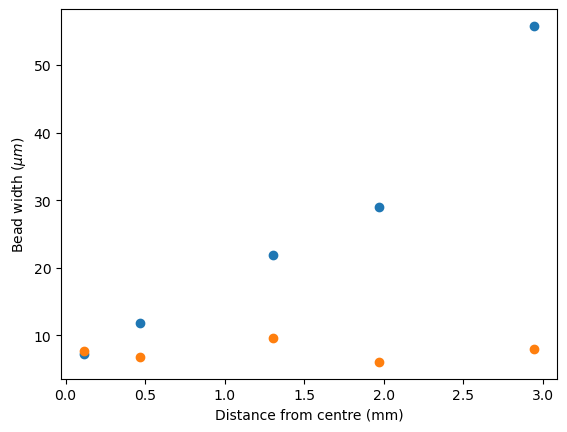

In [196]:
excel = pd.read_excel('../../OPT Shared files/2_Saved reconstructions/fd_focal scan/bead profiles.xlsx')
excel.head()

image_size = 1038
c = image_size //2
e = 6.45/1000 # pixel_size in mm

# extract these values from the excel file
x = excel.iloc[0].dropna().values[1:].astype(np.float64)
y = 2*c - excel.iloc[1].dropna().values[1:].astype(np.float64)
slice = excel.iloc[2].dropna().values[1:].astype(np.int16)

angles = np.arctan2((y-c), (x-c))*180/np.pi
r = np.sqrt((x-c)**2 + (y-c)**2)*e
print(r)
###

selected = [2,  4, 6, -2, -3]
dy = 50
fd_infocus = BeadDataset('../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco')
fd_infocus.set_bead_locations(x[selected], y[selected], slice[selected])
# fd_infocus.set_bead_locations(x,y,slice)
_ = fd_infocus.get_rotated_slices()
fd_infocus.fit_all_beads()

plt.scatter(fd_infocus.r, fd_infocus.tangential_widths)
plt.scatter(fd_infocus.r, fd_infocus.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')

## Aperture scanning dataset

Taken 01/03/2023


f_a

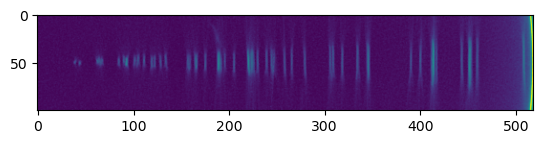

In [197]:
bead_positions = pd.read_excel('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/bead_positions.xlsx')
(x,y,slice) = bead_positions[['x', 'y', 'slice']].dropna().values.T
f_a = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 f6/reco')
# selected=[8,9]
f_a.set_bead_locations(x,y,slice)
# f_a.set_bead_locations(x[selected],y[selected],slice[selected])
f_a.get_rotated_slices(polarity=+1)
f_a.gen_bead_figure(display=True)
plt.show()
f_a.fit_all_beads()

Text(0.5, 0, 'Distance from centre (mm)')

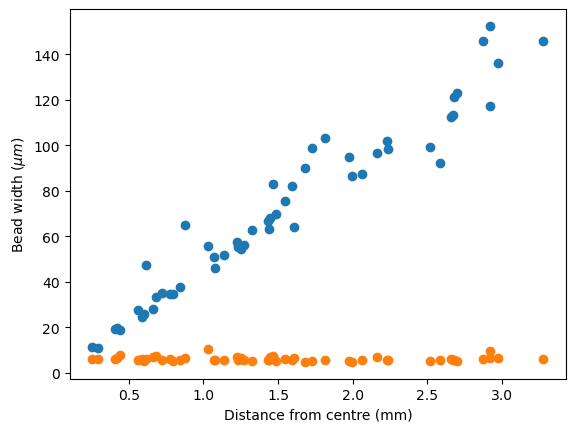

In [198]:
plt.scatter(f_a.r, f_a.tangential_widths)
plt.scatter(f_a.r, f_a.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')

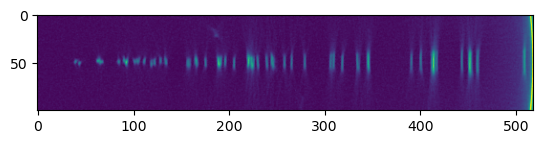

(0.0, 150.0)

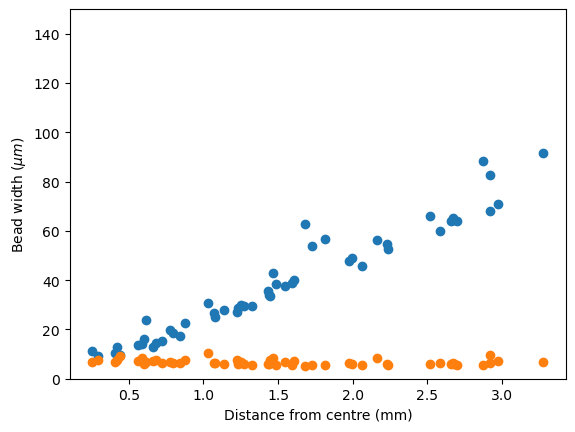

In [199]:
f_c = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 fc/reco')
f_c.set_bead_locations(x,y,slice)
f_c.get_rotated_slices(polarity=+1)
f_c.gen_bead_figure(display=True)
plt.show()
f_c.fit_all_beads()

# Plot
plt.scatter(f_c.r, f_c.tangential_widths)
plt.scatter(f_c.r, f_c.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.ylim(0,150)

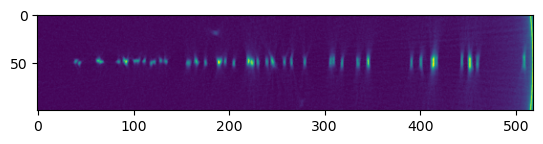

(0.0, 150.0)

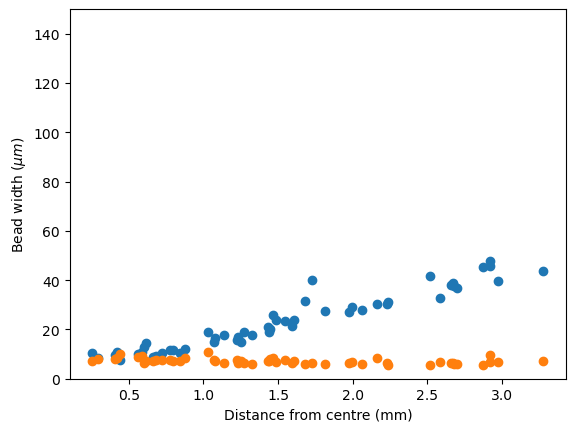

In [200]:
f_d = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 fd/reco')
f_d.set_bead_locations(x,y,slice)
f_d.get_rotated_slices(polarity=+1)
f_d.gen_bead_figure(display=True)
plt.show()
f_d.fit_all_beads()

# Plot
plt.scatter(f_d.r, f_d.tangential_widths)
plt.scatter(f_d.r, f_d.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.ylim(0,150)

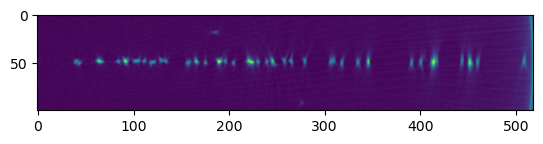

(0.0, 150.0)

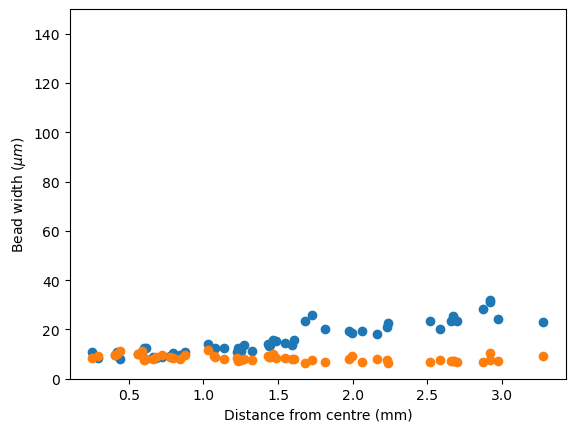

In [201]:
f_e = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 fe/reco')
f_e.set_bead_locations(x,y,slice)
f_e.get_rotated_slices(polarity=+1)
f_e.gen_bead_figure(display=True)
plt.show()
f_e.fit_all_beads()

# Plot
plt.scatter(f_e.r, f_e.tangential_widths)
plt.scatter(f_e.r, f_e.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.ylim(0,150)

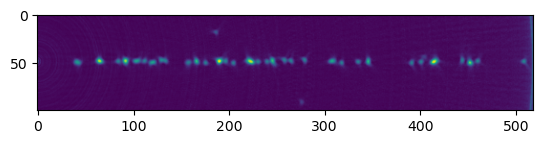

(0.0, 150.0)

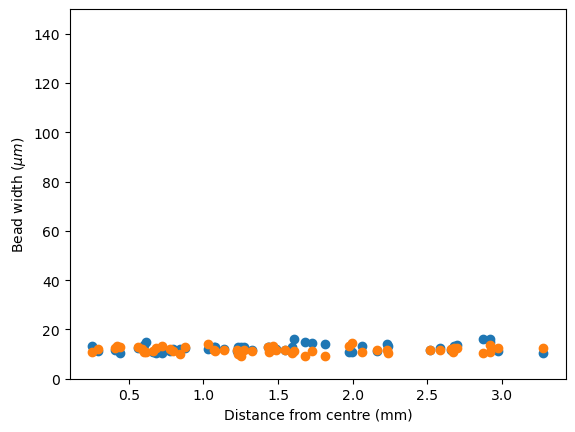

In [202]:
f_f = BeadDataset('../../OPT Shared files/2_Saved reconstructions/2023-03-01 aperture sweep/2023-03-01 ff/reco')
f_f.set_bead_locations(x,y,slice)
f_f.get_rotated_slices(polarity=+1)
f_f.gen_bead_figure(display=True)
plt.show()
f_f.fit_all_beads()

# Plot
plt.scatter(f_f.r, f_f.tangential_widths)
plt.scatter(f_f.r, f_f.radial_widths)

plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.ylim(0,150)

In [216]:
f_numbers = [  6.,   11.02426219,  16.71845468, 25.92260749,  47.376144]

Binned plots

<ErrorbarContainer object of 3 artists>

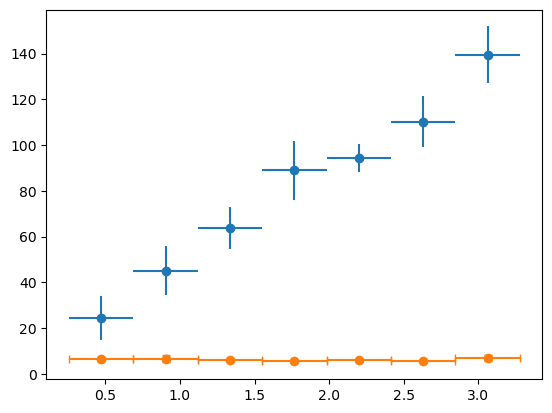

In [204]:

def bin_data(x,y, num_bins):
    binned_y, bin_edges, binnumber =  binned_statistic(x,y , bins=num_bins)
    binned_x  = (bin_edges[1:] + bin_edges[0:-1])/2
    binned_x_err = (bin_edges[1] - bin_edges[0])/2
    binned_y_std, _, _ = binned_statistic(x, y, statistic='std', bins=num_bins)
    return binned_x, binned_y, binned_x_err, binned_y_std

num_bins = 7

x,y, x_err, y_std = bin_data(f_a.r, f_a.tangential_widths, num_bins)
plt.scatter(x,y )
plt.errorbar(x,y, yerr=y_std, xerr=x_err, ls='')

x,y, x_err, y_std = bin_data(f_a.r, f_a.radial_widths, num_bins)
plt.scatter(x,y )
plt.errorbar(x,y, yerr=y_std, xerr=x_err, ls='', capsize=3)

In [221]:
f_a.bin_bead_widths(num_bins=num_bins)
f_c.bin_bead_widths(num_bins=num_bins)
f_d.bin_bead_widths(num_bins=num_bins)
f_e.bin_bead_widths(num_bins=num_bins)
f_f.bin_bead_widths(num_bins=num_bins)

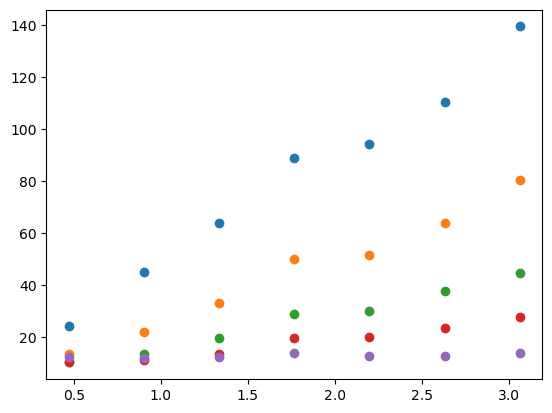

In [222]:
plt.scatter(f_a.binned_r, f_a.binned_tangential)
plt.scatter(f_c.binned_r, f_c.binned_tangential)
plt.scatter(f_d.binned_r, f_d.binned_tangential)
plt.scatter(f_e.binned_r, f_e.binned_tangential)
plt.scatter(f_f.binned_r, f_f.binned_tangential)

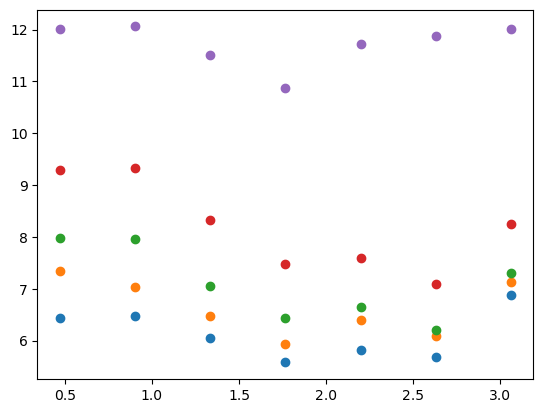

In [228]:
plt.scatter(f_a.binned_r, f_a.binned_radial)
plt.scatter(f_c.binned_r, f_c.binned_radial)
plt.scatter(f_d.binned_r, f_d.binned_radial)
plt.scatter(f_e.binned_r, f_e.binned_radial)
plt.scatter(f_f.binned_r, f_f.binned_radial)

(0.0, 60.0)

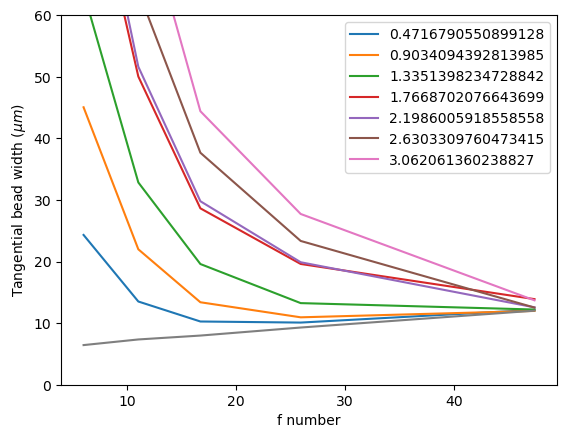

In [230]:
f_numbers = [  6.,   11.02426219,  16.71845468, 25.92260749,  47.376144]
for i in range(len(f_a.binned_r)):

    plt.plot(f_numbers, [f_a.binned_tangential[i], f_c.binned_tangential[i], f_d.binned_tangential[i],f_e.binned_tangential[i], f_f.binned_tangential[i]], label=f_a.binned_r[i])

plt.ylabel('Tangential bead width ($\mu m$)')
plt.xlabel('f number')
plt.legend()

plt.plot(f_numbers, [f_a.binned_radial[0], f_c.binned_radial[0], f_d.binned_radial[0],f_e.binned_radial[0], f_f.binned_radial[0]], label=f_a.binned_r[0])

plt.ylim(0,60)